In [69]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train loader:
batch size: 64
channels: 1
height: 28
width: 28

test loader:
batch size: 64
channels: 1
height: 28
width: 28


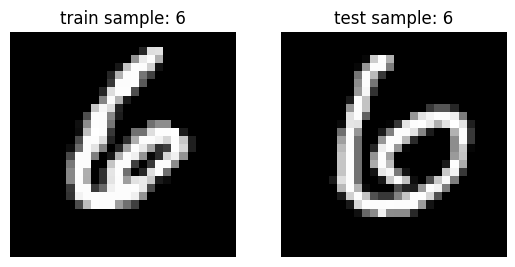

In [68]:
mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

y_train = mnist_train.targets
nines_mask = y_train != 9 # remove all nines from train

X_train = mnist_train.data[nines_mask]
y_train = mnist_train.targets[nines_mask]

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

X_test = mnist_test.data
y_test = mnist_test.targets

test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



def print_info(loader):
    X_batch, _ = loader.dataset[0]
    print("batch size:", loader.batch_size)
    print("channels:", X_batch.shape[0])
    print("height:", X_batch.shape[1])
    print("width:", X_batch.shape[2])

print("train loader:")
print_info(train_loader)
print("\ntest loader:")
print_info(test_loader)



num = 6
train_x, train_y = train_loader.dataset[y_train == num]
test_x, test_y = test_loader.dataset[y_test == num]

plt.subplot(1, 2, 1)
plt.imshow(train_x[0].squeeze(), cmap='gray')
plt.title(f'train sample: {train_y[0]}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(test_x[0].squeeze(), cmap='gray')
plt.title(f'test sample: {test_y[0]}')
plt.axis('off')

plt.show()

In [70]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X, _ in train_loader:
        X = X.float().to(device) / 255.0
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, X)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader)}")